<a href="https://colab.research.google.com/github/Gowri-Sanjeev/DEEP-LEARNING/blob/main/CycleGAN_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00


In [ ]:
!pip install datasets torch torchvision matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import io

# Image transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = load_dataset("huggan/monet2photo")

# Custom dataset class
class MonetPhotoDataset(Dataset):
    def __init__(self, split="train", limit=None):
        self.monet_imgs = dataset[split]['imageA'][:limit]
        self.photo_imgs = dataset[split]['imageB'][:limit]
        self.transform = transform

    def __len__(self):
        return min(len(self.monet_imgs), len(self.photo_imgs))

    def __getitem__(self, idx):
        monet_img = Image.open(io.BytesIO(self.monet_imgs[idx]['bytes'])).convert('RGB')
        photo_img = Image.open(io.BytesIO(self.photo_imgs[idx]['bytes'])).convert('RGB')
        monet = self.transform(monet_img)
        photo = self.transform(photo_img)
        return photo, monet

# Use small subsets
train_dataset = MonetPhotoDataset(split="train", limit=2000)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = MonetPhotoDataset(split="test", limit=200)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
import torch
from torch import nn
import itertools
from torchvision.utils import save_image

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 7, 1, 3),
            nn.ReLU(),
            nn.Conv2d(64, 3, 7, 1, 3),
            nn.Tanh()
        )
    def forward(self, x):
        return self.net(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# Instantiate models
G = Generator().to(DEVICE)
F = Generator().to(DEVICE)
D_photo = Discriminator().to(DEVICE)
D_monet = Discriminator().to(DEVICE)

# Weight init
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

G.apply(weights_init)
F.apply(weights_init)
D_photo.apply(weights_init)
D_monet.apply(weights_init)


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

opt_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=0.0002)
opt_D = optim.Adam(itertools.chain(D_photo.parameters(), D_monet.parameters()), lr=0.0002)

EPOCHS = 300

for epoch in range(EPOCHS):
    for real_photo, real_monet in tqdm(train_loader):
        real_photo = real_photo.to(DEVICE)
        real_monet = real_monet.to(DEVICE)

        fake_monet = G(real_photo)
        fake_photo = F(real_monet)

        # Discriminator losses
        loss_D_monet = criterion_GAN(D_monet(real_monet), torch.ones_like(D_monet(real_monet))) + \
                       criterion_GAN(D_monet(fake_monet.detach()), torch.zeros_like(D_monet(fake_monet)))
        loss_D_photo = criterion_GAN(D_photo(real_photo), torch.ones_like(D_photo(real_photo))) + \
                       criterion_GAN(D_photo(fake_photo.detach()), torch.zeros_like(D_photo(fake_photo)))
        loss_D = (loss_D_monet + loss_D_photo) * 0.5

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Generator losses
        loss_G_GAN = criterion_GAN(D_monet(fake_monet), torch.ones_like(D_monet(fake_monet)))
        loss_F_GAN = criterion_GAN(D_photo(fake_photo), torch.ones_like(D_photo(fake_photo)))
        loss_cycle = criterion_cycle(F(fake_monet), real_photo) + criterion_cycle(G(fake_photo), real_monet)
        loss_G = loss_G_GAN + loss_F_GAN + 10 * loss_cycle

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    save_image(fake_monet.data[:1], f"monet_epoch_{epoch}.png", normalize=True)
    print(f"Epoch {epoch+1}/{EPOCHS} done.")


In [ ]:
import matplotlib.pyplot as plt

def stylize_image(img_path, generator_model):
    # Load and preprocess input image
    original = Image.open(img_path).convert("RGB")
    img = transform(original).unsqueeze(0).to(DEVICE)

    # Generate stylized image
    generator_model.eval()
    with torch.no_grad():
        styled = generator_model(img)

    # Convert tensors back to image
    styled_img = styled.squeeze(0).detach().cpu()
    styled_img = styled_img * 0.5 + 0.5  # Denormalize
    styled_img = transforms.ToPILImage()(styled_img)

    # Display original and stylized images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(styled_img)
    axs[1].set_title("Monet Style Image")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Optionally save
    styled_img.save("styled_output.png")
    print("Styled image saved as styled_output.png")

# Example usage:
# stylize_image("your_photo.jpg", G)

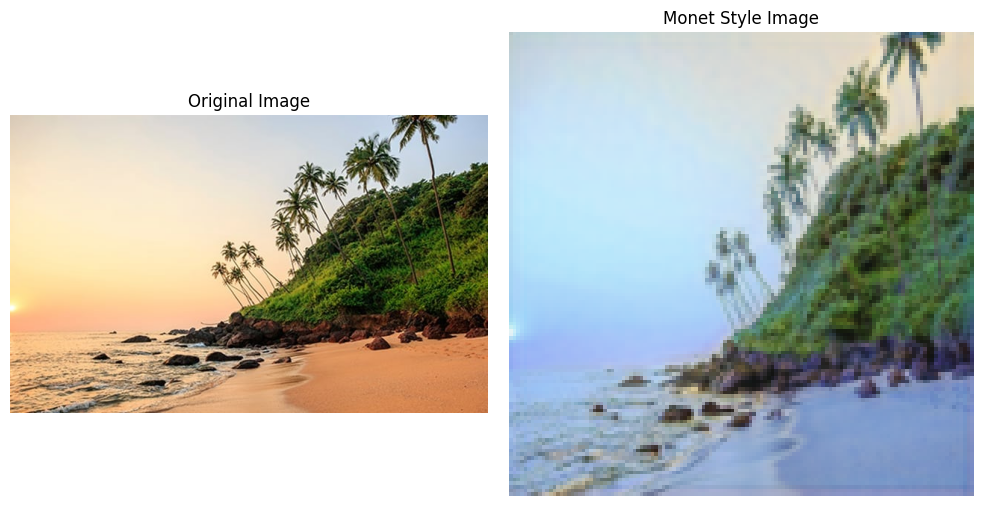

Styled image saved as styled_output.png


In [ ]:
stylize_image("/content/m_destination-goa-landscape_l_400_640.jpg", G)

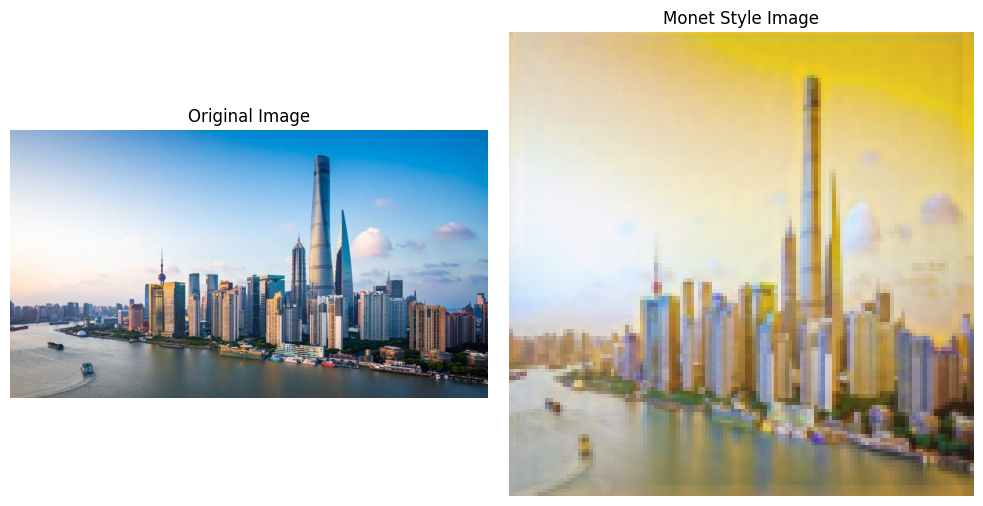

Styled image saved as styled_output.png


In [ ]:
stylize_image("/content/tall-buildings-past-present-hero-banner.jpg", G)

In [ ]:
stylize_image("/content/tall-buildings-past-present-hero-banner.jpg", G)